In [19]:
#Modulos a usar
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Analisis de Riesgo Crediticio

#### Dataset via web que iremos analizando paso a paso.

In [15]:
df= pd.read_csv("lending_data.csv")
#Vistazo de los datos
df.head(5)


,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,52800,0.431818,5,1,22800,0
1,8400.0,6.692,43600,0.311927,3,0,13600,0
2,9000.0,6.963,46100,0.349241,3,0,16100,0
3,10700.0,7.664,52700,0.430740,5,1,22700,0
4,10800.0,7.698,53000,0.433962,5,1,23000,0


##### Averiguamos que tan positiva o negativa es la correlacion entre la variables independiente Y (loan_status) y las variables de entrada. Como podemos ver la correlacion es positiva con todas las caractersticas siendo mas fuerte en algunos casos.
<u> Al tener tan pocas caracteristicas nuestro dataset no es necesario eliminar las variables de entrada con una alta correlacion entre si, pero es necesario saber que un caso de informacion mas extensa es buena practica para ahorrar recursos computacionales.</u>

In [16]:
#Correlacion entre las variables, siendo loan_status la de salida.
df.corr()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
loan_size,1.000000,0.999905,0.999893,0.951847,0.988507,0.840407,0.999893,0.758846
interest_rate,0.999905,1.000000,0.999994,0.951938,0.988515,0.840596,0.999994,0.758900
borrower_income,0.999893,0.999994,1.000000,0.951950,0.988509,0.840577,1.000000,0.758890
debt_to_income,0.951847,0.951938,0.951950,1.000000,0.941078,0.825668,0.951950,0.589305
num_of_accounts,0.988507,0.988515,0.988509,0.941078,1.000000,0.818320,0.988509,0.749802
derogatory_marks,0.840407,0.840596,0.840577,0.825668,0.818320,1.000000,0.840577,0.553187
total_debt,0.999893,0.999994,1.000000,0.951950,0.988509,0.840577,1.000000,0.758890
loan_status,0.758846,0.758900,0.758890,0.589305,0.749802,0.553187,0.758890,1.000000


#### Una descripcion general de las variables es buena practica porque nos ayudara a detectar si son nesarias ciertas optimizaciones.
#### Por ejemplo, viendo el min y max nos dara una intuición si es necesario escalar los datos de dicha variable para generar un analisis mas preciso.

In [17]:
df.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804,0.032243
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077,0.176646
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000,0.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000,0.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000,0.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000,1.000000


#### A continuacion generamos boxplots de cada una de las caracteristas para deteccion de posbiles ouliners.

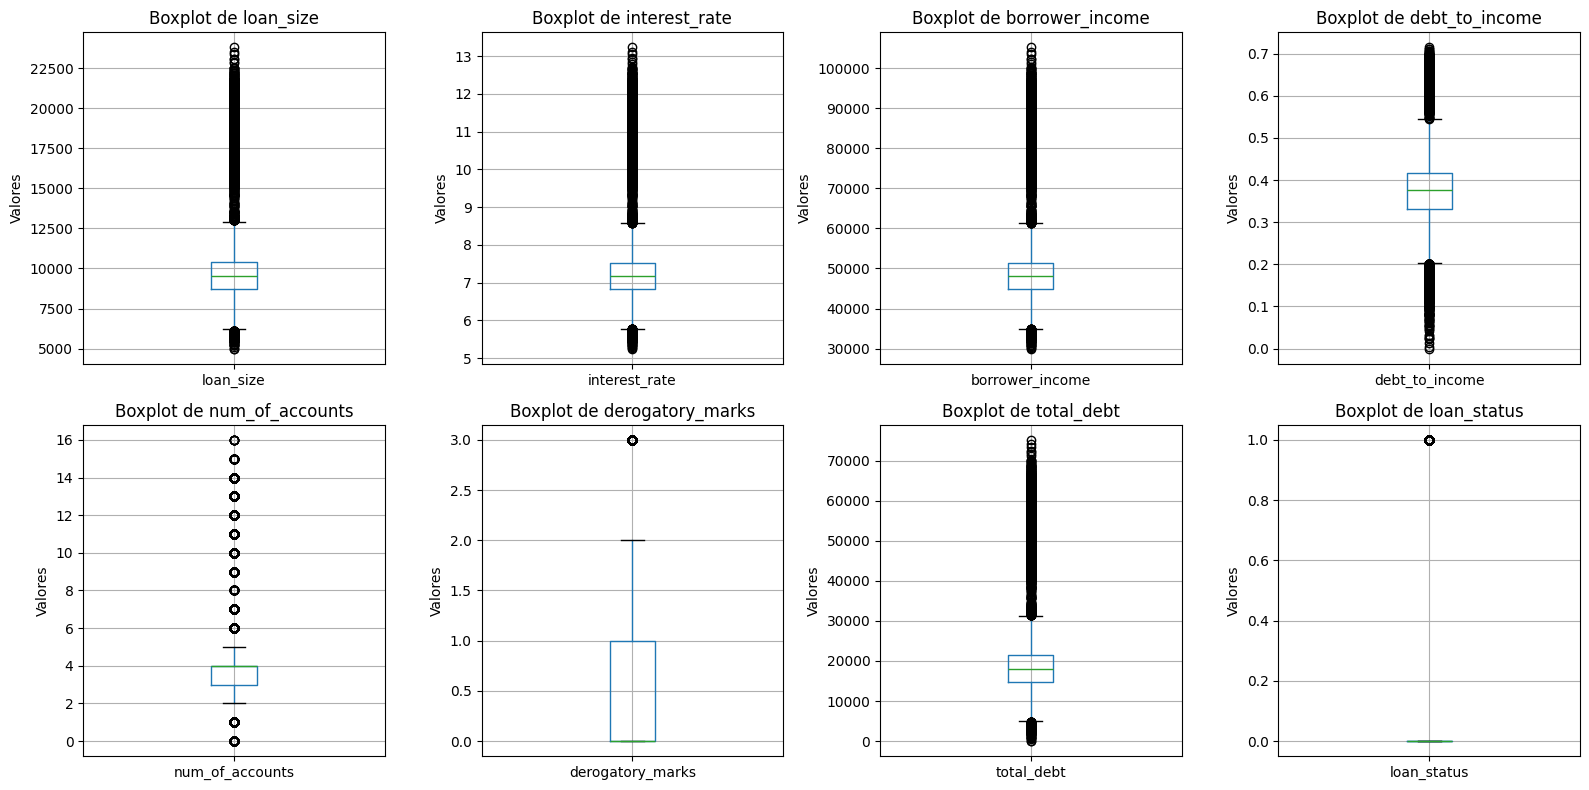

In [23]:
num_cols = len(df.columns)

# Calculo de el número de filas y columnas para los subplots
num_rows = 1
if num_cols > 4:
    num_rows = num_cols // 4 + (1 if num_cols % 4 > 0 else 0)

# Configuracion de la figura y los subplots
fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4*num_rows))
axes = axes.flatten()

# Generacion de boxplots para cada característica
for i, column in enumerate(df.columns):
    df.boxplot(column=[column], ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}')
    axes[i].set_ylabel('Valores')

# Ajuste de diseño
plt.tight_layout()
plt.show()

#### Dividemos el conjunto de datos en tres para ir realizando las pruebas de prediccion y sobreajuste de los datos

In [27]:
from sklearn.model_selection import train_test_split
#Division del conjunto de datos para realizar las pruebas
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [25]:
print("Longitud del conjunto de datos:", len(df))

Longitud del conjunto de datos: 77536


##### Con el stratify buscon una homogeneidad en la division de los datos. La idea es que los 3 subconjuntos tengan datos con similares caracteristicas.

In [49]:
train_set, val_set, test_set = train_val_test_split(df)

In [51]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 46521
Longitud del Validation Set: 15507
Longitud del Test Set: 15508


<Axes: >

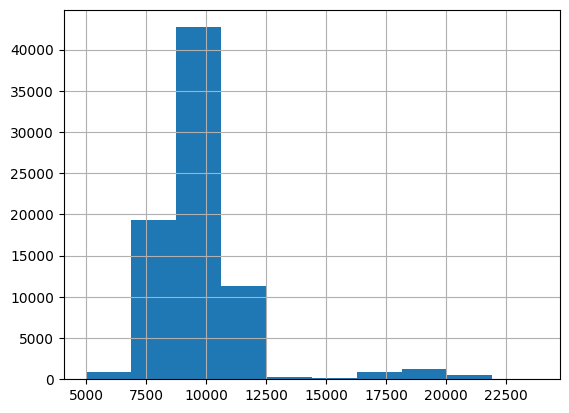

In [53]:
# Comprobación de que stratify mantiene la proporcion de la característica en los conjuntos
%matplotlib inline
import matplotlib.pyplot as plt
df["loan_size"].hist()

#### Como vemos se mantiene una dispersion similar entre los 3 subconjuntos

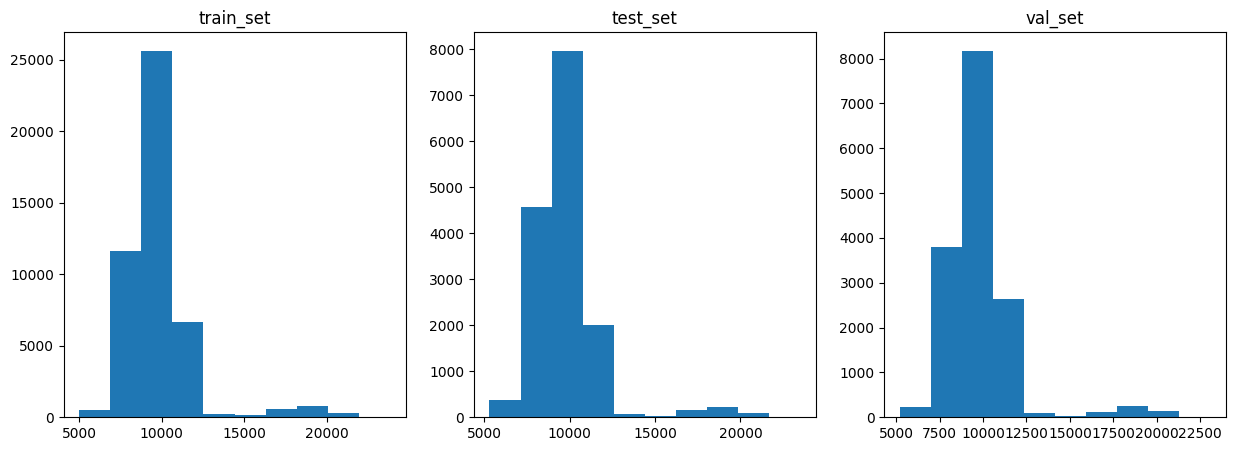

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Gráfico para train_set
axs[0].hist(train_set["loan_size"])
axs[0].set_title('train_set')

# Gráfico para test_set
axs[1].hist(test_set["loan_size"])
axs[1].set_title('test_set')

# Gráfico para val_set
axs[2].hist(val_set["loan_size"])
axs[2].set_title('val_set')

# Mostrar los gráficos
plt.show()

#### Division de las variables de entrada respecto a la de salida para cada subconjunto

In [62]:
#Divison train
X_train = train_set.drop("loan_status", axis=1)
y_train = train_set["loan_status"].copy()
#Division test
X_test = test_set.drop("loan_status", axis=1)
y_test = test_set["loan_status"].copy()
#Validacion test
X_val = val_set.drop("loan_status",axis=1)
y_val = val_set["loan_status"].copy()

#### Chequeo balance y (Siendo 1 el positivo)

In [64]:
y_train.value_counts()

loan_status
0    44962
1     1559
Name: count, dtype: int64

# Creacion del Modelo de Regresión Logistica

In [65]:
# Importacion de modulo
from sklearn.linear_model import LogisticRegression

# Instanciar el modelo
# Semilla 42
logistic_regression_model = LogisticRegression(solver='lbfgs', random_state=42)

# Ajuste de modelo usando los datos de entrenamiento
lr_model = logistic_regression_model.fit(X_train, y_train)

## Prediccion usando las variables de entrada de los datos de prueba

In [66]:
# Prediccion
test_predictions = logistic_regression_model.predict(X_test)
pd.DataFrame({'Predictions': test_predictions, 'Actual': y_test})

,Predictions,Actual
46991,0,0
24451,0,0
9433,0,0
10544,0,0
23947,0,0
...,...,...
22782,0,0
77238,1,1
71904,0,0
17616,0,0


# Evaluacion del Modelo con datos de prueba

In [72]:
# Presicion del Modelo con los datos de prueba
print(f"La precision del modelo es de : {balanced_accuracy_score(y_test, test_predictions)}")

La precision del modelo es de : 0.9711683918287253


In [75]:
# Matriz de confusion del modelo
cf_test_matrix = confusion_matrix(y_test, test_predictions)
cf_test_matrix      

array([[14979,    74],
       [   24,   431]], dtype=int64)

In [74]:
# Reporte de clasificacion del modelo
testing_report = classification_report(y_test, test_predictions)
print(testing_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15053
           1       0.85      0.95      0.90       455

    accuracy                           0.99     15508
   macro avg       0.93      0.97      0.95     15508
weighted avg       0.99      0.99      0.99     15508



# Evaluacion del Modelo con datos de validación

In [78]:
# Prediccion
val_predictions = logistic_regression_model.predict(X_val)
pd.DataFrame({'Predictions': val_predictions, 'Actual': y_val})

,Predictions,Actual
58756,0,0
24388,0,0
14424,0,0
34548,0,0
43288,0,0
...,...,...
71715,0,0
53748,0,0
50930,0,0
41963,0,0


In [79]:
# Presicion del Modelo con los datos de validacion
print(f"La precision del modelo es de : {balanced_accuracy_score(y_val, val_predictions)}")

La precision del modelo es de : 0.9770605103472423


In [80]:
# Matriz de confusion del modelo
cf_val_matrix = confusion_matrix(y_val, val_predictions)
cf_val_matrix      

array([[14950,    71],
       [   20,   466]], dtype=int64)

In [81]:
# Reporte de clasificacion del modelo
testing_report = classification_report(y_val, val_predictions)
print(testing_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15021
           1       0.87      0.96      0.91       486

    accuracy                           0.99     15507
   macro avg       0.93      0.98      0.95     15507
weighted avg       0.99      0.99      0.99     15507



#### Similar rendimiento. El modelo funciona muy bien